Detected 76 particles.


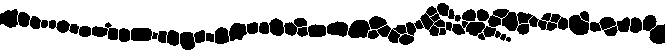

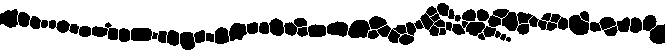

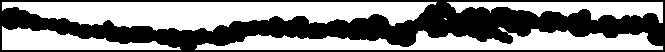

C:\Users\MAGIC\anaconda3\envs\uber\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
C:\Users\MAGIC\anaconda3\envs\uber\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "int32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

In [1]:
import numpy as np
import cv2
import k3d
from IPython.display import Image, display
import random

# Enable interactive mode for matplotlib
%matplotlib notebook

image_path = r"C:\Users\MAGIC\Desktop\1-39.tif"

def show_image(image, title="Image"):
    _, tmp_png = cv2.imencode('.png', image)
    display(Image(data=tmp_png, format='png', width=500))

def detect_particles(image_path, particle_threshold=255, area_threshold=2000):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Adaptive thresholding
    _, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Extract particle information (center, axes, angle, z_position)
    particles = []
    for contour in contours:
        if cv2.contourArea(contour) < area_threshold and len(contour) >= 5:
            # Use minAreaRect to get the RotatedRect
            temp = cv2.minAreaRect(contour)
            # Extract relevant information from RotatedRect
            center, (w, h), angle = temp
            # Append z_position as the second element in the tuple, rotate angle by 90 degrees
            particles.append(((center[0], center[1]), (w, h), angle , 0))

    if not particles:
        print("No particles detected.")
    else:
        print(f"Detected {len(particles)} particles.")

    # Visualize intermediate steps
    show_image(img, "Original Image")
    show_image(binary_image, "Binary Image")

    # Draw contours on the original image
    img_with_contours = img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)
    show_image(img_with_contours, "Contours")

    return particles

# ... (rest of the code remains the same)

def adjust_overlapping_particles(particles):
    for i in range(len(particles)):
        for j in range(i + 1, len(particles)):
            center_i, axes_i, angle_i, z_i = particles[i]
            center_j, axes_j, angle_j, z_j = particles[j]

            # Get the bounding boxes of the ellipses
            bbox_i = cv2.boundingRect(np.intp(cv2.ellipse2Poly((int(center_i[0]), int(center_i[1])),
                                                               (int(axes_i[0] / 2), int(axes_i[1] / 2)),
                                                               int(angle_i), 0, 360, 5)))
            bbox_j = cv2.boundingRect(np.intp(cv2.ellipse2Poly((int(center_j[0]), int(center_j[1])),
                                                               (int(axes_j[0] / 2), int(axes_j[1] / 2)),
                                                               int(angle_j), 0, 360, 5)))

            # Calculate the overlapping area
            intersection = (max(0, min(bbox_i[0] + bbox_i[2], bbox_j[0] + bbox_j[2]) - max(bbox_i[0], bbox_j[0])) *
                            max(0, min(bbox_i[1] + bbox_i[3], bbox_j[1] + bbox_j[3]) - max(bbox_i[1], bbox_j[1])))

            # Calculate the percentage of overlap based on the area of the smaller ellipse
            overlap_percentage = intersection / min(cv2.contourArea(cv2.ellipse2Poly((int(center_i[0]), int(center_i[1])),
                                                                                      (int(axes_i[0] / 2), int(axes_i[1] / 2)),
                                                                                      int(angle_i), 0, 360, 5)),
                                                     cv2.contourArea(cv2.ellipse2Poly((int(center_j[0]), int(center_j[1])),
                                                                                      (int(axes_j[0] / 2), int(axes_j[1] / 2)),
                                                                                      int(angle_j), 0, 360, 5)))

            # Move particles randomly based on the overlapping area
            move_distance = np.random.uniform(-overlap_percentage * 6, overlap_percentage * 6)
            particles[i] = (center_i, axes_i, angle_i, z_i + move_distance)
            particles[j] = (center_j, axes_j, angle_j, z_j - move_distance)
def connect_particles_mesh(particles):
    # Create a list to store vertices and faces of the mesh
    vertices = []
    faces = []

    for particle in particles:
        center, axes, angle, z_position = particle

        # Ensure that the axes tuple has at least two elements
        if len(axes) >= 2:
            # Parametric equations of a sphere in 3D
            phi = np.linspace(0, 2 * np.pi, 100)
            theta = np.linspace(0, np.pi, 50)
            phi, theta = np.meshgrid(phi, theta)

            x = center[0] + axes[0] / 2 * np.sin(theta) * np.cos(phi)
            y = center[1] + axes[1] / 2 * np.sin(theta) * np.sin(phi)
            z = z_position + axes[0] / 2 * np.cos(theta)  # Use the second element of axes for z

            # Append vertices
            vertices.extend(np.column_stack((x.flatten(), y.flatten(), z.flatten())))

            # Append faces
            num_points_phi = len(phi)
            for i in range(len(theta)-1):
                for j in range(len(phi)-1):
                    p1 = i * num_points_phi + j
                    p2 = (i + 1) * num_points_phi + j
                    p3 = (i + 1) * num_points_phi + (j + 1)
                    p4 = i * num_points_phi + (j + 1)

                    faces.append([p1, p2, p3])
                    faces.append([p1, p3, p4])

    # Convert vertices and faces to numpy arrays
    vertices = np.array(vertices)
    faces = np.array(faces)

    return vertices, faces

def visualize_particles_with_mesh_k3d(vertices, faces):
    # Create a K3D plot
    plot = k3d.plot()

    # Add the particles as points
    plot += k3d.points(vertices, point_size=0.05, color=0xffcc00)

    # Add the mesh
    plot += k3d.mesh(vertices, faces, opacity=0.5)

    # Display the K3D plot
    plot.display()

if __name__ == "__main__":
    particles = detect_particles(image_path)

    # Check if particles are detected before adjusting and visualizing
    if particles:
        # Adjust z-positions to avoid overlapping
        adjust_overlapping_particles(particles)

        vertices, faces = connect_particles_mesh(particles)
        visualize_particles_with_mesh_k3d(vertices, faces)
    else:
        print("No particles detected.")


In [2]:
particles

[((508.00006103515625, 39.000003814697266),
  (5.656853675842285, 5.656853675842285),
  45.0,
  0.9560077560823252),
 ((503.00006103515625, 36.50001907348633),
  (6.363960266113281, 7.77817440032959),
  45.0,
  -1.1571276823383778),
 ((406.0000305175781, 39.00003433227539),
  (12.727920532226562, 14.142135620117188),
  45.0,
  -1.2328263330857714),
 ((481.5000305175781, 36.500003814697266),
  (8.485280990600586, 7.071067810058594),
  45.0,
  2.2105479025126193),
 ((209.5, 37.0), (10.0, 9.0), 90.0, -0.6244202815515649),
 ((187.0, 40.5), (16.0, 19.0), 0.0, -0.39749918839184906),
 ((154.41177368164062, 35.352943420410156),
  (6.305926322937012, 8.246211051940918),
  14.03624439239502,
  -2.593985775397086),
 ((497.0, 33.9999885559082),
  (7.071067810058594, 7.071067810058594),
  45.0,
  -0.6154654661378473),
 ((162.0, 36.5), (10.0, 13.0), 0.0, 1.6125200716340367),
 ((372.2500305175781, 34.2499885559082),
  (10.60660171508789, 11.31370735168457),
  45.0,
  -0.5779357619279466),
 ((199.0, 3

In [3]:
calibration_factor = (2191.081 / 664.5) * 10**-9  # nm length over pixel length

def truncate_float(number, num_decimals=9):
    # Convert to string, truncate, and convert back to float
    str_number = f"{number:.{num_decimals}e}"
    truncated_number = float(str_number)
    return truncated_number

def rescale_particles(particles, calibration_factor):
    rescaled_particles = []

    for particle in particles:
        center, axes, angle, z_position = particle

        # Ensure that the axes tuple has at least two elements
        if len(axes) >= 2:
            # Update the center position based on the calibration factor
            center_x = truncate_float(center[0] * calibration_factor)
            center_y = truncate_float(center[1] * calibration_factor)

            # Update the axes lengths based on the calibration factor
            axes_x = truncate_float(axes[0] * calibration_factor)
            axes_y = truncate_float(axes[1] * calibration_factor)

            # Update the z-coordinate based on the calibration factor
            z_position = truncate_float(z_position * calibration_factor)
            angle = angle+90
            # Append the rescaled particle
            rescaled_particles.append(((center_x, center_y), (axes_x, axes_y), angle, z_position))

    return rescaled_particles

# Example usage:
rescaled_particles = rescale_particles(particles, calibration_factor)
particles = rescaled_particles

Detected 76 particles.


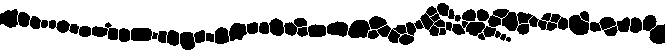

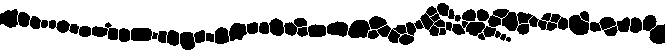

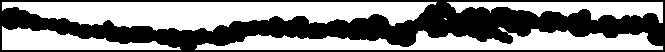

Output()

In [4]:
#TO CHECK PARTICLES AFTER RESCALING
def visualize_particles_with_mesh_k3d(vertices, faces):
    # Create a K3D plot
    plot = k3d.plot()

    # Add the particles as points
    plot += k3d.points(vertices, point_size=0.05, color=0xffcc00)

    # Add the mesh
    plot += k3d.mesh(vertices, faces, opacity=0.5)

    # Display the K3D plot
    plot.display()

if __name__ == "__main__":
    particles = detect_particles(image_path)

    # Check if particles are detected before adjusting and visualizing
    if particles:
        # Adjust z-positions to avoid overlapping
        adjust_overlapping_particles(particles)

        vertices, faces = connect_particles_mesh(particles)
        visualize_particles_with_mesh_k3d(vertices, faces)
    else:
        print("No particles detected.")


In [5]:
import pandas as pd

# Assuming particles is the rescaled_particles list
particles = rescaled_particles

# Extract components into separate lists
centers_x, centers_y = zip(*[(center[0], center[1]) for (center, _, _, _) in particles])
z_positions = [z for (_, _, _, z) in particles]
axes_x, axes_y = zip(*[(axes[0], axes[1]) for (_, axes, _, _) in particles])
angles = [angle for (_, _, angle, _) in particles]

# Create a Pandas DataFrame
rparticles = pd.DataFrame({
    'X': centers_x,
    'Y': centers_y,
    'Z': z_positions,
    'MI': axes_x,
    'MJ': axes_y,
    'Angle': angles
})

In [30]:
rparticles

,X,Y,Z,MI,MJ,Angle
0,1.675048e-06,1.285962e-07,3.152281e-09,1.865256e-08,1.865256e-08,135.000000
1,1.658561e-06,1.203529e-07,-3.815441e-09,2.098413e-08,2.564727e-08,135.000000
2,1.338719e-06,1.285963e-07,-4.065045e-09,4.196825e-08,4.663140e-08,135.000000
3,1.587668e-06,1.203528e-07,7.288923e-09,2.797884e-08,2.331570e-08,135.000000
4,6.907923e-07,1.220015e-07,-2.058925e-09,3.297338e-08,2.967604e-08,180.000000
...,...,...,...,...,...,...
71,1.590966e-06,4.781140e-08,-1.925466e-09,4.286539e-08,4.286539e-08,90.000000
72,1.544803e-06,4.781140e-08,1.120937e-10,4.946007e-08,4.286539e-08,90.000000
73,1.488124e-06,4.495964e-08,-6.435092e-10,2.547771e-08,3.740345e-08,99.462322
74,1.421977e-06,3.544638e-08,5.317442e-09,3.264198e-08,3.497355e-08,135.000000


In [31]:
#magnetic simulations

import oommfc as oc 
#import mumax3c as oc

import discretisedfield as df
from matplotlib import pyplot as plt
import micromagneticmodel as mm
import random
# Mehran Sedrpooshan
#previous parameters

#rparticles.at[0, 'X'] = 0
#rparticles.at[0, 'Y'] = 0
#rparticles.at[0, 'Z'] = 0
#rparticles.at[0, 'MJ'] = 25e-9
#rparticles.at[0, 'MI'] = 25e-9
#rparticles.at[0, 'Angle'] = 0

system = mm.System(name='f')
 
Ms = 1.4e6
#Mpcr = 0
#Ms_value = 8e5  # saturation magnetisation (A/m)
#A = 1e-12  # exchange energy constant (J/m)
#x50-2170, 0-170
p1=(50e-9, 0, -50e-9)
p2=(2170e-9, 170e-9, 60e-9)
cell = (2e-9, 2e-9, 2e-9)

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)
#def m_fun(pos) : #   return [2*random.random()-1 for i in range(3)]

# Assuming EE is your ellipsoid equation function
def EE(x, y, z, x_0, y_0, z_0, a, b, angle):
    # Convert angle to radians
    angle_rad = angle * (np.pi / 180.0)
    # Rotate coordinates
    x_rot = (x - x_0) * np.cos(angle_rad) + (y - y_0) * np.sin(angle_rad)
    y_rot = (y - y_0) * np.cos(angle_rad) - (x - x_0) * np.sin(angle_rad)
    z_rot = z - z_0  # Assuming z_0 is the center of rotation

     # Ellipsoid equation
    equation = (x_rot / a)**2 + (y_rot / b)**2 + ((z_rot / a)**2) <= 0.225
    return equation

#number of particles from 0

def ellipsoid_magnetization(pos):
    x, y, z = pos
    if EE(x, y, z, rparticles.at[0, 'X'], rparticles.at[0, 'Y'], rparticles.at[0, 'Z'], rparticles.at[0, 'MJ'], rparticles.at[0, 'MI'], rparticles.at[0, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[1, 'X'], rparticles.at[1, 'Y'], rparticles.at[1, 'Z'], rparticles.at[1, 'MJ'], rparticles.at[1, 'MI'], rparticles.at[1, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[2, 'X'], rparticles.at[2, 'Y'], rparticles.at[2, 'Z'], rparticles.at[2, 'MJ'], rparticles.at[2, 'MI'], rparticles.at[2, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[3, 'X'], rparticles.at[3, 'Y'], rparticles.at[3, 'Z'], rparticles.at[3, 'MJ'], rparticles.at[3, 'MI'], rparticles.at[3, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[4, 'X'], rparticles.at[4, 'Y'], rparticles.at[4, 'Z'], rparticles.at[4, 'MJ'], rparticles.at[4, 'MI'], rparticles.at[4, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[5, 'X'], rparticles.at[5, 'Y'], rparticles.at[5, 'Z'], rparticles.at[5, 'MJ'], rparticles.at[5, 'MI'], rparticles.at[5, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[6, 'X'], rparticles.at[6, 'Y'], rparticles.at[6, 'Z'], rparticles.at[6, 'MJ'], rparticles.at[6, 'MI'], rparticles.at[6, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[7, 'X'], rparticles.at[7, 'Y'], rparticles.at[7, 'Z'], rparticles.at[7, 'MJ'], rparticles.at[7, 'MI'], rparticles.at[7, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[8, 'X'], rparticles.at[8, 'Y'], rparticles.at[8, 'Z'], rparticles.at[8, 'MJ'], rparticles.at[8, 'MI'], rparticles.at[8, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[9, 'X'], rparticles.at[9, 'Y'], rparticles.at[9, 'Z'], rparticles.at[9, 'MJ'], rparticles.at[9, 'MI'], rparticles.at[9, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[10, 'X'], rparticles.at[10, 'Y'], rparticles.at[10, 'Z'], rparticles.at[10, 'MJ'], rparticles.at[10, 'MI'], rparticles.at[10, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[11, 'X'], rparticles.at[11, 'Y'], rparticles.at[11, 'Z'], rparticles.at[11, 'MJ'], rparticles.at[11, 'MI'], rparticles.at[11, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[12, 'X'], rparticles.at[12, 'Y'], rparticles.at[12, 'Z'], rparticles.at[12, 'MJ'], rparticles.at[12, 'MI'], rparticles.at[12, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[13, 'X'], rparticles.at[13, 'Y'], rparticles.at[13, 'Z'], rparticles.at[13, 'MJ'], rparticles.at[13, 'MI'], rparticles.at[13, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[14, 'X'], rparticles.at[14, 'Y'], rparticles.at[14, 'Z'], rparticles.at[14, 'MJ'], rparticles.at[14, 'MI'], rparticles.at[14, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[15, 'X'], rparticles.at[15, 'Y'], rparticles.at[15, 'Z'], rparticles.at[15, 'MJ'], rparticles.at[15, 'MI'], rparticles.at[15, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[16, 'X'], rparticles.at[16, 'Y'], rparticles.at[16, 'Z'], rparticles.at[16, 'MJ'], rparticles.at[16, 'MI'], rparticles.at[16, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[17, 'X'], rparticles.at[17, 'Y'], rparticles.at[17, 'Z'], rparticles.at[17, 'MJ'], rparticles.at[17, 'MI'], rparticles.at[17, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[18, 'X'], rparticles.at[18, 'Y'], rparticles.at[18, 'Z'], rparticles.at[18, 'MJ'], rparticles.at[18, 'MI'], rparticles.at[18, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[19, 'X'], rparticles.at[19, 'Y'], rparticles.at[19, 'Z'], rparticles.at[19, 'MJ'], rparticles.at[19, 'MI'], rparticles.at[19, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[20, 'X'], rparticles.at[20, 'Y'], rparticles.at[20, 'Z'], rparticles.at[20, 'MJ'], rparticles.at[20, 'MI'], rparticles.at[20, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[21, 'X'], rparticles.at[21, 'Y'], rparticles.at[21, 'Z'], rparticles.at[21, 'MJ'], rparticles.at[21, 'MI'], rparticles.at[21, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[22, 'X'], rparticles.at[22, 'Y'], rparticles.at[22, 'Z'], rparticles.at[22, 'MJ'], rparticles.at[22, 'MI'], rparticles.at[22, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[23, 'X'], rparticles.at[23, 'Y'], rparticles.at[23, 'Z'], rparticles.at[23, 'MJ'], rparticles.at[23, 'MI'], rparticles.at[23, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[24, 'X'], rparticles.at[24, 'Y'], rparticles.at[24, 'Z'], rparticles.at[24, 'MJ'], rparticles.at[24, 'MI'], rparticles.at[24, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[25, 'X'], rparticles.at[25, 'Y'], rparticles.at[25, 'Z'], rparticles.at[25, 'MJ'], rparticles.at[25, 'MI'], rparticles.at[25, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[26, 'X'], rparticles.at[26, 'Y'], rparticles.at[26, 'Z'], rparticles.at[26, 'MJ'], rparticles.at[26, 'MI'], rparticles.at[26, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[27, 'X'], rparticles.at[27, 'Y'], rparticles.at[27, 'Z'], rparticles.at[27, 'MJ'], rparticles.at[27, 'MI'], rparticles.at[27, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[28, 'X'], rparticles.at[28, 'Y'], rparticles.at[28, 'Z'], rparticles.at[28, 'MJ'], rparticles.at[28, 'MI'], rparticles.at[28, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[29, 'X'], rparticles.at[29, 'Y'], rparticles.at[29, 'Z'], rparticles.at[29, 'MJ'], rparticles.at[29, 'MI'], rparticles.at[29, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[30, 'X'], rparticles.at[30, 'Y'], rparticles.at[30, 'Z'], rparticles.at[30, 'MJ'], rparticles.at[30, 'MI'], rparticles.at[30, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[31, 'X'], rparticles.at[31, 'Y'], rparticles.at[31, 'Z'], rparticles.at[31, 'MJ'], rparticles.at[31, 'MI'], rparticles.at[31, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[32, 'X'], rparticles.at[32, 'Y'], rparticles.at[32, 'Z'], rparticles.at[32, 'MJ'], rparticles.at[32, 'MI'], rparticles.at[32, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[33, 'X'], rparticles.at[33, 'Y'], rparticles.at[33, 'Z'], rparticles.at[33, 'MJ'], rparticles.at[33, 'MI'], rparticles.at[33, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[34, 'X'], rparticles.at[34, 'Y'], rparticles.at[34, 'Z'], rparticles.at[34, 'MJ'], rparticles.at[34, 'MI'], rparticles.at[34, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[35, 'X'], rparticles.at[35, 'Y'], rparticles.at[35, 'Z'], rparticles.at[35, 'MJ'], rparticles.at[35, 'MI'], rparticles.at[35, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[36, 'X'], rparticles.at[36, 'Y'], rparticles.at[36, 'Z'], rparticles.at[36, 'MJ'], rparticles.at[36, 'MI'], rparticles.at[36, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[37, 'X'], rparticles.at[37, 'Y'], rparticles.at[37, 'Z'], rparticles.at[37, 'MJ'], rparticles.at[37, 'MI'], rparticles.at[37, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[38, 'X'], rparticles.at[38, 'Y'], rparticles.at[38, 'Z'], rparticles.at[38, 'MJ'], rparticles.at[38, 'MI'], rparticles.at[38, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[39, 'X'], rparticles.at[39, 'Y'], rparticles.at[39, 'Z'], rparticles.at[39, 'MJ'], rparticles.at[39, 'MI'], rparticles.at[39, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[40, 'X'], rparticles.at[40, 'Y'], rparticles.at[40, 'Z'], rparticles.at[40, 'MJ'], rparticles.at[40, 'MI'], rparticles.at[40, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[41, 'X'], rparticles.at[41, 'Y'], rparticles.at[41, 'Z'], rparticles.at[41, 'MJ'], rparticles.at[41, 'MI'], rparticles.at[41, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[42, 'X'], rparticles.at[42, 'Y'], rparticles.at[42, 'Z'], rparticles.at[42, 'MJ'], rparticles.at[42, 'MI'], rparticles.at[42, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[43, 'X'], rparticles.at[43, 'Y'], rparticles.at[43, 'Z'], rparticles.at[43, 'MJ'], rparticles.at[43, 'MI'], rparticles.at[43, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[44, 'X'], rparticles.at[44, 'Y'], rparticles.at[44, 'Z'], rparticles.at[44, 'MJ'], rparticles.at[44, 'MI'], rparticles.at[44, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[45, 'X'], rparticles.at[45, 'Y'], rparticles.at[45, 'Z'], rparticles.at[45, 'MJ'], rparticles.at[45, 'MI'], rparticles.at[45, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[46, 'X'], rparticles.at[46, 'Y'], rparticles.at[46, 'Z'], rparticles.at[46, 'MJ'], rparticles.at[46, 'MI'], rparticles.at[46, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[47, 'X'], rparticles.at[47, 'Y'], rparticles.at[47, 'Z'], rparticles.at[47, 'MJ'], rparticles.at[47, 'MI'], rparticles.at[47, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[48, 'X'], rparticles.at[48, 'Y'], rparticles.at[48, 'Z'], rparticles.at[48, 'MJ'], rparticles.at[48, 'MI'], rparticles.at[48, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[49, 'X'], rparticles.at[49, 'Y'], rparticles.at[49, 'Z'], rparticles.at[49, 'MJ'], rparticles.at[49, 'MI'], rparticles.at[49, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[50, 'X'], rparticles.at[50, 'Y'], rparticles.at[50, 'Z'], rparticles.at[50, 'MJ'], rparticles.at[50, 'MI'], rparticles.at[50, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[51, 'X'], rparticles.at[51, 'Y'], rparticles.at[51, 'Z'], rparticles.at[51, 'MJ'], rparticles.at[51, 'MI'], rparticles.at[51, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[52, 'X'], rparticles.at[52, 'Y'], rparticles.at[52, 'Z'], rparticles.at[52, 'MJ'], rparticles.at[52, 'MI'], rparticles.at[52, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[53, 'X'], rparticles.at[53, 'Y'], rparticles.at[53, 'Z'], rparticles.at[53, 'MJ'], rparticles.at[53, 'MI'], rparticles.at[53, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[54, 'X'], rparticles.at[54, 'Y'], rparticles.at[54, 'Z'], rparticles.at[54, 'MJ'], rparticles.at[54, 'MI'], rparticles.at[54, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[55, 'X'], rparticles.at[55, 'Y'], rparticles.at[55, 'Z'], rparticles.at[55, 'MJ'], rparticles.at[55, 'MI'], rparticles.at[55, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[56, 'X'], rparticles.at[56, 'Y'], rparticles.at[56, 'Z'], rparticles.at[56, 'MJ'], rparticles.at[56, 'MI'], rparticles.at[56, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[57, 'X'], rparticles.at[57, 'Y'], rparticles.at[57, 'Z'], rparticles.at[57, 'MJ'], rparticles.at[57, 'MI'], rparticles.at[57, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[58, 'X'], rparticles.at[58, 'Y'], rparticles.at[58, 'Z'], rparticles.at[58, 'MJ'], rparticles.at[58, 'MI'], rparticles.at[58, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[59, 'X'], rparticles.at[59, 'Y'], rparticles.at[59, 'Z'], rparticles.at[59, 'MJ'], rparticles.at[59, 'MI'], rparticles.at[59, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[60, 'X'], rparticles.at[60, 'Y'], rparticles.at[60, 'Z'], rparticles.at[60, 'MJ'], rparticles.at[60, 'MI'], rparticles.at[60, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[61, 'X'], rparticles.at[61, 'Y'], rparticles.at[61, 'Z'], rparticles.at[61, 'MJ'], rparticles.at[61, 'MI'], rparticles.at[61, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[62, 'X'], rparticles.at[62, 'Y'], rparticles.at[62, 'Z'], rparticles.at[62, 'MJ'], rparticles.at[62, 'MI'], rparticles.at[62, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[63, 'X'], rparticles.at[63, 'Y'], rparticles.at[63, 'Z'], rparticles.at[63, 'MJ'], rparticles.at[63, 'MI'], rparticles.at[63, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[64, 'X'], rparticles.at[64, 'Y'], rparticles.at[64, 'Z'], rparticles.at[64, 'MJ'], rparticles.at[64, 'MI'], rparticles.at[64, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[65, 'X'], rparticles.at[65, 'Y'], rparticles.at[65, 'Z'], rparticles.at[65, 'MJ'], rparticles.at[65, 'MI'], rparticles.at[65, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[66, 'X'], rparticles.at[66, 'Y'], rparticles.at[66, 'Z'], rparticles.at[66, 'MJ'], rparticles.at[66, 'MI'], rparticles.at[66, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[67, 'X'], rparticles.at[67, 'Y'], rparticles.at[67, 'Z'], rparticles.at[67, 'MJ'], rparticles.at[67, 'MI'], rparticles.at[67, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[68, 'X'], rparticles.at[68, 'Y'], rparticles.at[68, 'Z'], rparticles.at[68, 'MJ'], rparticles.at[68, 'MI'], rparticles.at[68, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[69, 'X'], rparticles.at[69, 'Y'], rparticles.at[69, 'Z'], rparticles.at[69, 'MJ'], rparticles.at[69, 'MI'], rparticles.at[69, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[70, 'X'], rparticles.at[70, 'Y'], rparticles.at[70, 'Z'], rparticles.at[70, 'MJ'], rparticles.at[70, 'MI'], rparticles.at[70, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[71, 'X'], rparticles.at[71, 'Y'], rparticles.at[71, 'Z'], rparticles.at[71, 'MJ'], rparticles.at[71, 'MI'], rparticles.at[71, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[72, 'X'], rparticles.at[72, 'Y'], rparticles.at[72, 'Z'], rparticles.at[72, 'MJ'], rparticles.at[72, 'MI'], rparticles.at[72, 'Angle']):
        return Ms

    if EE(x, y, z, rparticles.at[73, 'X'], rparticles.at[73, 'Y'], rparticles.at[73, 'Z'], rparticles.at[73, 'MJ'], rparticles.at[73, 'MI'], rparticles.at[73, 'Angle']):
        return Ms
    if EE(x, y, z, rparticles.at[74, 'X'], rparticles.at[74, 'Y'], rparticles.at[74, 'Z'], rparticles.at[74, 'MJ'], rparticles.at[74, 'MI'], rparticles.at[74, 'Angle']):
        return Ms
    if EE(x, y, z, rparticles.at[75, 'X'], rparticles.at[75, 'Y'], rparticles.at[75, 'Z'], rparticles.at[75, 'MJ'], rparticles.at[75, 'MI'], rparticles.at[75, 'Angle']):
        return Ms
    else:
        return 0

#def u_fun1(pos):
#    return (-0.2905507099841792, 0.37796235993098637, 0.8790476320445263)

#def u_fun2(pos):
#    return (-0.5357451734863272, 0.6969231295409805, -0.47673395158821125)


# Set a seed for reproducibility
np.random.seed(42)



def u_fun1(pos):
    x, y, z = pos
    if EE(x, y, z, rparticles.at[0, 'X'], rparticles.at[0, 'Y'], rparticles.at[0, 'Z'], rparticles.at[0, 'MJ'], rparticles.at[0, 'MI'], rparticles.at[0, 'Angle']):
        return (-0.26069734475138173, 0.4716424796549184, 0.8423718097280672)

    if EE(x, y, z, rparticles.at[1, 'X'], rparticles.at[1, 'Y'], rparticles.at[1, 'Z'], rparticles.at[1, 'MJ'], rparticles.at[1, 'MI'], rparticles.at[1, 'Angle']):
        return (-0.354797479878095, 0.41692351266987937, 0.8368354275812907)

    if EE(x, y, z, rparticles.at[2, 'X'], rparticles.at[2, 'Y'], rparticles.at[2, 'Z'], rparticles.at[2, 'MJ'], rparticles.at[2, 'MI'], rparticles.at[2, 'Angle']):
        return (0.6102268356294952, 0.5446483496698894, 0.5753098159074629)

    if EE(x, y, z, rparticles.at[3, 'X'], rparticles.at[3, 'Y'], rparticles.at[3, 'Z'], rparticles.at[3, 'MJ'], rparticles.at[3, 'MI'], rparticles.at[3, 'Angle']):
        return (-0.689185129629909, 0.18894951009419053, 0.6995155035681275)

    if EE(x, y, z, rparticles.at[4, 'X'], rparticles.at[4, 'Y'], rparticles.at[4, 'Z'], rparticles.at[4, 'MJ'], rparticles.at[4, 'MI'], rparticles.at[4, 'Angle']):
        return (-0.555044716393412, 0.732567813327953, 0.39404284244185694)

    if EE(x, y, z, rparticles.at[5, 'X'], rparticles.at[5, 'Y'], rparticles.at[5, 'Z'], rparticles.at[5, 'MJ'], rparticles.at[5, 'MI'], rparticles.at[5, 'Angle']):
        return (0.2822493152230003, -0.4766433172694557, 0.8325541857191737)

    if EE(x, y, z, rparticles.at[6, 'X'], rparticles.at[6, 'Y'], rparticles.at[6, 'Z'], rparticles.at[6, 'MJ'], rparticles.at[6, 'MI'], rparticles.at[6, 'Angle']):
        return (-0.5988787539276523, 0.4348435030154841, 0.6724993427352068)

    if EE(x, y, z, rparticles.at[7, 'X'], rparticles.at[7, 'Y'], rparticles.at[7, 'Z'], rparticles.at[7, 'MJ'], rparticles.at[7, 'MI'], rparticles.at[7, 'Angle']):
        return (-0.03102391307669915, -0.902540533876342, 0.4294858571916156)

    if EE(x, y, z, rparticles.at[8, 'X'], rparticles.at[8, 'Y'], rparticles.at[8, 'Z'], rparticles.at[8, 'MJ'], rparticles.at[8, 'MI'], rparticles.at[8, 'Angle']):
        return (0.5461722270955792, -0.340495728003842, 0.765348650982406)

    if EE(x, y, z, rparticles.at[9, 'X'], rparticles.at[9, 'Y'], rparticles.at[9, 'Z'], rparticles.at[9, 'MJ'], rparticles.at[9, 'MI'], rparticles.at[9, 'Angle']):
        return (-0.09721696591699423, -0.49827350905173884, 0.8615523035284397)

    if EE(x, y, z, rparticles.at[10, 'X'], rparticles.at[10, 'Y'], rparticles.at[10, 'Z'], rparticles.at[10, 'MJ'], rparticles.at[10, 'MI'], rparticles.at[10, 'Angle']):
        return (0.9718057526590194, 0.16055645993135187, 0.17267079160399096)

    if EE(x, y, z, rparticles.at[11, 'X'], rparticles.at[11, 'Y'], rparticles.at[11, 'Z'], rparticles.at[11, 'MJ'], rparticles.at[11, 'MI'], rparticles.at[11, 'Angle']):
        return (0.901743815769127, -0.3847462742328385, 0.19704922021181476)

    if EE(x, y, z, rparticles.at[12, 'X'], rparticles.at[12, 'Y'], rparticles.at[12, 'Z'], rparticles.at[12, 'MJ'], rparticles.at[12, 'MI'], rparticles.at[12, 'Angle']):
        return (0.43337128431583694, 0.8486609430355325, 0.3032555583933835)

    if EE(x, y, z, rparticles.at[13, 'X'], rparticles.at[13, 'Y'], rparticles.at[13, 'Z'], rparticles.at[13, 'MJ'], rparticles.at[13, 'MI'], rparticles.at[13, 'Angle']):
        return (0.949165927240109, 0.31396372414313595, 0.02260138244880088)

    if EE(x, y, z, rparticles.at[14, 'X'], rparticles.at[14, 'Y'], rparticles.at[14, 'Z'], rparticles.at[14, 'MJ'], rparticles.at[14, 'MI'], rparticles.at[14, 'Angle']):
        return (0.14993362818455677, 0.9143463181191691, 0.37615251917451564)

    if EE(x, y, z, rparticles.at[15, 'X'], rparticles.at[15, 'Y'], rparticles.at[15, 'Z'], rparticles.at[15, 'MJ'], rparticles.at[15, 'MI'], rparticles.at[15, 'Angle']):
        return (0.9097626206393721, 0.32478792030834264, 0.25854357642216474)

    if EE(x, y, z, rparticles.at[16, 'X'], rparticles.at[16, 'Y'], rparticles.at[16, 'Z'], rparticles.at[16, 'MJ'], rparticles.at[16, 'MI'], rparticles.at[16, 'Angle']):
        return (0.06932400147632357, -0.8467323984820695, 0.5274831070092317)

    if EE(x, y, z, rparticles.at[17, 'X'], rparticles.at[17, 'Y'], rparticles.at[17, 'Z'], rparticles.at[17, 'MJ'], rparticles.at[17, 'MI'], rparticles.at[17, 'Angle']):
        return (0.0706393892841112, -0.6708047772713303, 0.7382621671679572)

    if EE(x, y, z, rparticles.at[18, 'X'], rparticles.at[18, 'Y'], rparticles.at[18, 'Z'], rparticles.at[18, 'MJ'], rparticles.at[18, 'MI'], rparticles.at[18, 'Angle']):
        return (0.3554612587539465, 0.49133680722844775, 0.7951323382856561)

    if EE(x, y, z, rparticles.at[19, 'X'], rparticles.at[19, 'Y'], rparticles.at[19, 'Z'], rparticles.at[19, 'MJ'], rparticles.at[19, 'MI'], rparticles.at[19, 'Angle']):
        return (-0.8654176286937244, 0.20651585846279752, 0.4565123526800833)

    if EE(x, y, z, rparticles.at[20, 'X'], rparticles.at[20, 'Y'], rparticles.at[20, 'Z'], rparticles.at[20, 'MJ'], rparticles.at[20, 'MI'], rparticles.at[20, 'Angle']):
        return (-0.3494883687655924, 0.878068035553342, 0.3268859205243628)

    if EE(x, y, z, rparticles.at[21, 'X'], rparticles.at[21, 'Y'], rparticles.at[21, 'Z'], rparticles.at[21, 'MJ'], rparticles.at[21, 'MI'], rparticles.at[21, 'Angle']):
        return (0.8219775773116885, 0.0411205959360685, 0.5680334136181336)

    if EE(x, y, z, rparticles.at[22, 'X'], rparticles.at[22, 'Y'], rparticles.at[22, 'Z'], rparticles.at[22, 'MJ'], rparticles.at[22, 'MI'], rparticles.at[22, 'Angle']):
        return (0.21734072153439699, -0.2851905795786672, 0.9335037997150797)

    if EE(x, y, z, rparticles.at[23, 'X'], rparticles.at[23, 'Y'], rparticles.at[23, 'Z'], rparticles.at[23, 'MJ'], rparticles.at[23, 'MI'], rparticles.at[23, 'Angle']):
        return (-0.9750942281713252, -0.1770817222036215, 0.13354141622870058)

    if EE(x, y, z, rparticles.at[24, 'X'], rparticles.at[24, 'Y'], rparticles.at[24, 'Z'], rparticles.at[24, 'MJ'], rparticles.at[24, 'MI'], rparticles.at[24, 'Angle']):
        return (0.034489217173298795, -0.3519453708334268, 0.9353849206865026)

    if EE(x, y, z, rparticles.at[25, 'X'], rparticles.at[25, 'Y'], rparticles.at[25, 'Z'], rparticles.at[25, 'MJ'], rparticles.at[25, 'MI'], rparticles.at[25, 'Angle']):
        return (0.9451522696049893, 0.020558686020727506, 0.3259824039570827)

    if EE(x, y, z, rparticles.at[26, 'X'], rparticles.at[26, 'Y'], rparticles.at[26, 'Z'], rparticles.at[26, 'MJ'], rparticles.at[26, 'MI'], rparticles.at[26, 'Angle']):
        return (0.00189049814631723, -0.31649321108351397, 0.9485928912630566)

    if EE(x, y, z, rparticles.at[27, 'X'], rparticles.at[27, 'Y'], rparticles.at[27, 'Z'], rparticles.at[27, 'MJ'], rparticles.at[27, 'MI'], rparticles.at[27, 'Angle']):
        return (0.8770500112456383, -0.4559888917432359, 0.15118666733809993)

    if EE(x, y, z, rparticles.at[28, 'X'], rparticles.at[28, 'Y'], rparticles.at[28, 'Z'], rparticles.at[28, 'MJ'], rparticles.at[28, 'MI'], rparticles.at[28, 'Angle']):
        return (-0.6887005604185382, -0.45742555866107387, 0.5625419063170279)

    if EE(x, y, z, rparticles.at[29, 'X'], rparticles.at[29, 'Y'], rparticles.at[29, 'Z'], rparticles.at[29, 'MJ'], rparticles.at[29, 'MI'], rparticles.at[29, 'Angle']):
        return (-0.36251332327446867, -0.8105406122679312, 0.46000870243162567)

    if EE(x, y, z, rparticles.at[30, 'X'], rparticles.at[30, 'Y'], rparticles.at[30, 'Z'], rparticles.at[30, 'MJ'], rparticles.at[30, 'MI'], rparticles.at[30, 'Angle']):
        return (-0.9499555509573369, -0.058776759088651036, 0.3068057101756375)

    if EE(x, y, z, rparticles.at[31, 'X'], rparticles.at[31, 'Y'], rparticles.at[31, 'Z'], rparticles.at[31, 'MJ'], rparticles.at[31, 'MI'], rparticles.at[31, 'Angle']):
        return (0.777665352195056, -0.5415419218281657, 0.31932576923573897)

    if EE(x, y, z, rparticles.at[32, 'X'], rparticles.at[32, 'Y'], rparticles.at[32, 'Z'], rparticles.at[32, 'MJ'], rparticles.at[32, 'MI'], rparticles.at[32, 'Angle']):
        return (0.7451338314807087, -0.6645837448623493, 0.05571372584574478)

    if EE(x, y, z, rparticles.at[33, 'X'], rparticles.at[33, 'Y'], rparticles.at[33, 'Z'], rparticles.at[33, 'MJ'], rparticles.at[33, 'MI'], rparticles.at[33, 'Angle']):
        return (0.4236997040100663, -0.03857137932217206, 0.9049811100343296)

    if EE(x, y, z, rparticles.at[34, 'X'], rparticles.at[34, 'Y'], rparticles.at[34, 'Z'], rparticles.at[34, 'MJ'], rparticles.at[34, 'MI'], rparticles.at[34, 'Angle']):
        return (-0.04009745503049784, -0.03692673948832066, 0.99851319971788)

    if EE(x, y, z, rparticles.at[35, 'X'], rparticles.at[35, 'Y'], rparticles.at[35, 'Z'], rparticles.at[35, 'MJ'], rparticles.at[35, 'MI'], rparticles.at[35, 'Angle']):
        return (-0.4532484012494211, -0.23192803858261377, 0.8606830262553488)

    if EE(x, y, z, rparticles.at[36, 'X'], rparticles.at[36, 'Y'], rparticles.at[36, 'Z'], rparticles.at[36, 'MJ'], rparticles.at[36, 'MI'], rparticles.at[36, 'Angle']):
        return (-0.8158216082118085, -0.4578250720247792, 0.3533147421212484)

    if EE(x, y, z, rparticles.at[37, 'X'], rparticles.at[37, 'Y'], rparticles.at[37, 'Z'], rparticles.at[37, 'MJ'], rparticles.at[37, 'MI'], rparticles.at[37, 'Angle']):
        return (-0.7127822728628402, 0.37872733404558107, 0.5903448466271307)

    if EE(x, y, z, rparticles.at[38, 'X'], rparticles.at[38, 'Y'], rparticles.at[38, 'Z'], rparticles.at[38, 'MJ'], rparticles.at[38, 'MI'], rparticles.at[38, 'Angle']):
        return (-0.06628871563380982, -0.9065351239005311, 0.41689312217194047)

    if EE(x, y, z, rparticles.at[39, 'X'], rparticles.at[39, 'Y'], rparticles.at[39, 'Z'], rparticles.at[39, 'MJ'], rparticles.at[39, 'MI'], rparticles.at[39, 'Angle']):
        return (0.23282248827242005, -0.5806975411277054, 0.7801179748492375)

    if EE(x, y, z, rparticles.at[40, 'X'], rparticles.at[40, 'Y'], rparticles.at[40, 'Z'], rparticles.at[40, 'MJ'], rparticles.at[40, 'MI'], rparticles.at[40, 'Angle']):
        return (0.6962548109537376, 0.3651707338270221, 0.6179640550873564)

    if EE(x, y, z, rparticles.at[41, 'X'], rparticles.at[41, 'Y'], rparticles.at[41, 'Z'], rparticles.at[41, 'MJ'], rparticles.at[41, 'MI'], rparticles.at[41, 'Angle']):
        return (0.3717162328276858, 0.42038462185249476, 0.827709980586394)

    if EE(x, y, z, rparticles.at[42, 'X'], rparticles.at[42, 'Y'], rparticles.at[42, 'Z'], rparticles.at[42, 'MJ'], rparticles.at[42, 'MI'], rparticles.at[42, 'Angle']):
        return (0.19582014778168624, 0.5580086070885507, 0.8063999405616632)

    if EE(x, y, z, rparticles.at[43, 'X'], rparticles.at[43, 'Y'], rparticles.at[43, 'Z'], rparticles.at[43, 'MJ'], rparticles.at[43, 'MI'], rparticles.at[43, 'Angle']):
        return (-0.9337364279814582, -0.3571511131907586, 0.024070010532390308)

    if EE(x, y, z, rparticles.at[44, 'X'], rparticles.at[44, 'Y'], rparticles.at[44, 'Z'], rparticles.at[44, 'MJ'], rparticles.at[44, 'MI'], rparticles.at[44, 'Angle']):
        return (-0.18509228558281582, -0.9438391962500771, 0.273694021563749)

    if EE(x, y, z, rparticles.at[45, 'X'], rparticles.at[45, 'Y'], rparticles.at[45, 'Z'], rparticles.at[45, 'MJ'], rparticles.at[45, 'MI'], rparticles.at[45, 'Angle']):
        return (0.4322142318058642, 0.5844232433750749, 0.686760751956185)

    if EE(x, y, z, rparticles.at[46, 'X'], rparticles.at[46, 'Y'], rparticles.at[46, 'Z'], rparticles.at[46, 'MJ'], rparticles.at[46, 'MI'], rparticles.at[46, 'Angle']):
        return (0.22546335367793438, 0.8248264423640708, 0.5184858880676783)

    if EE(x, y, z, rparticles.at[47, 'X'], rparticles.at[47, 'Y'], rparticles.at[47, 'Z'], rparticles.at[47, 'MJ'], rparticles.at[47, 'MI'], rparticles.at[47, 'Angle']):
        return (0.7964119378834165, 0.591877435080743, 0.12413350490106163)

    if EE(x, y, z, rparticles.at[48, 'X'], rparticles.at[48, 'Y'], rparticles.at[48, 'Z'], rparticles.at[48, 'MJ'], rparticles.at[48, 'MI'], rparticles.at[48, 'Angle']):
        return (-0.04915458175560407, -0.9956080656935493, 0.07967688885982575)

    if EE(x, y, z, rparticles.at[49, 'X'], rparticles.at[49, 'Y'], rparticles.at[49, 'Z'], rparticles.at[49, 'MJ'], rparticles.at[49, 'MI'], rparticles.at[49, 'Angle']):
        return (0.6429128842590554, -0.7522452363638713, 0.1441878206422641)

    if EE(x, y, z, rparticles.at[50, 'X'], rparticles.at[50, 'Y'], rparticles.at[50, 'Z'], rparticles.at[50, 'MJ'], rparticles.at[50, 'MI'], rparticles.at[50, 'Angle']):
        return (0.060390601590013054, -0.7182986372637317, 0.6931089690262725)

    if EE(x, y, z, rparticles.at[51, 'X'], rparticles.at[51, 'Y'], rparticles.at[51, 'Z'], rparticles.at[51, 'MJ'], rparticles.at[51, 'MI'], rparticles.at[51, 'Angle']):
        return (0.20546182072373484, 0.19566773718042818, 0.9589054055805394)

    if EE(x, y, z, rparticles.at[52, 'X'], rparticles.at[52, 'Y'], rparticles.at[52, 'Z'], rparticles.at[52, 'MJ'], rparticles.at[52, 'MI'], rparticles.at[52, 'Angle']):
        return (0.5389755835718947, 0.8261271107941375, 0.16437553687902187)

    if EE(x, y, z, rparticles.at[53, 'X'], rparticles.at[53, 'Y'], rparticles.at[53, 'Z'], rparticles.at[53, 'MJ'], rparticles.at[53, 'MI'], rparticles.at[53, 'Angle']):
        return (-0.6086303370944784, 0.7863432601807677, 0.10598768766485532)

    if EE(x, y, z, rparticles.at[54, 'X'], rparticles.at[54, 'Y'], rparticles.at[54, 'Z'], rparticles.at[54, 'MJ'], rparticles.at[54, 'MI'], rparticles.at[54, 'Angle']):
        return (0.9418763498239031, -0.32816005777150037, 0.07197164806926358)

    if EE(x, y, z, rparticles.at[55, 'X'], rparticles.at[55, 'Y'], rparticles.at[55, 'Z'], rparticles.at[55, 'MJ'], rparticles.at[55, 'MI'], rparticles.at[55, 'Angle']):
        return (-0.5175839378843307, -0.6606341332994063, 0.5437549164503173)

    if EE(x, y, z, rparticles.at[56, 'X'], rparticles.at[56, 'Y'], rparticles.at[56, 'Z'], rparticles.at[56, 'MJ'], rparticles.at[56, 'MI'], rparticles.at[56, 'Angle']):
        return (0.7643193329962527, 0.18858255991651282, 0.6166462318894832)

    if EE(x, y, z, rparticles.at[57, 'X'], rparticles.at[57, 'Y'], rparticles.at[57, 'Z'], rparticles.at[57, 'MJ'], rparticles.at[57, 'MI'], rparticles.at[57, 'Angle']):
        return (0.42115737842345063, -0.3903323549517686, 0.8186984275527179)

    if EE(x, y, z, rparticles.at[58, 'X'], rparticles.at[58, 'Y'], rparticles.at[58, 'Z'], rparticles.at[58, 'MJ'], rparticles.at[58, 'MI'], rparticles.at[58, 'Angle']):
        return (0.3121632356481222, 0.44851074778725636, 0.8374916258859016)

    if EE(x, y, z, rparticles.at[59, 'X'], rparticles.at[59, 'Y'], rparticles.at[59, 'Z'], rparticles.at[59, 'MJ'], rparticles.at[59, 'MI'], rparticles.at[59, 'Angle']):
        return (-0.6397214776213939, 0.33965910352077705, 0.6894839551906647)

    if EE(x, y, z, rparticles.at[60, 'X'], rparticles.at[60, 'Y'], rparticles.at[60, 'Z'], rparticles.at[60, 'MJ'], rparticles.at[60, 'MI'], rparticles.at[60, 'Angle']):
        return (-0.5592034113187987, 0.31593160977070694, 0.7664716320367689)

    if EE(x, y, z, rparticles.at[61, 'X'], rparticles.at[61, 'Y'], rparticles.at[61, 'Z'], rparticles.at[61, 'MJ'], rparticles.at[61, 'MI'], rparticles.at[61, 'Angle']):
        return (-0.43949821314649107, -0.8313076513726508, 0.34024830552161256)

    if EE(x, y, z, rparticles.at[62, 'X'], rparticles.at[62, 'Y'], rparticles.at[62, 'Z'], rparticles.at[62, 'MJ'], rparticles.at[62, 'MI'], rparticles.at[62, 'Angle']):
        return (0.22770453353026585, 0.6520632915428067, 0.723162574551618)

    if EE(x, y, z, rparticles.at[63, 'X'], rparticles.at[63, 'Y'], rparticles.at[63, 'Z'], rparticles.at[63, 'MJ'], rparticles.at[63, 'MI'], rparticles.at[63, 'Angle']):
        return (-0.531684865378728, 0.7789993407301958, 0.3323721273950693)

    if EE(x, y, z, rparticles.at[64, 'X'], rparticles.at[64, 'Y'], rparticles.at[64, 'Z'], rparticles.at[64, 'MJ'], rparticles.at[64, 'MI'], rparticles.at[64, 'Angle']):
        return (-0.16198682230070577, 0.08533014832665495, 0.9830966560758259)

    if EE(x, y, z, rparticles.at[65, 'X'], rparticles.at[65, 'Y'], rparticles.at[65, 'Z'], rparticles.at[65, 'MJ'], rparticles.at[65, 'MI'], rparticles.at[65, 'Angle']):
        return (-0.8637778380040259, 0.16954239134982796, 0.4744925964738255)

    if EE(x, y, z, rparticles.at[66, 'X'], rparticles.at[66, 'Y'], rparticles.at[66, 'Z'], rparticles.at[66, 'MJ'], rparticles.at[66, 'MI'], rparticles.at[66, 'Angle']):
        return (0.4124840715805439, 0.620390977524524, 0.6670621602958021)

    if EE(x, y, z, rparticles.at[67, 'X'], rparticles.at[67, 'Y'], rparticles.at[67, 'Z'], rparticles.at[67, 'MJ'], rparticles.at[67, 'MI'], rparticles.at[67, 'Angle']):
        return (-0.9786361014750584, 0.20138299956886127, 0.041427869536669916)

    if EE(x, y, z, rparticles.at[68, 'X'], rparticles.at[68, 'Y'], rparticles.at[68, 'Z'], rparticles.at[68, 'MJ'], rparticles.at[68, 'MI'], rparticles.at[68, 'Angle']):
        return (0.42155435281757675, -0.8840751309854438, 0.20175006912916882)

    if EE(x, y, z, rparticles.at[69, 'X'], rparticles.at[69, 'Y'], rparticles.at[69, 'Z'], rparticles.at[69, 'MJ'], rparticles.at[69, 'MI'], rparticles.at[69, 'Angle']):
        return (-0.13963463236763962, 0.8022960593674862, 0.5803647151291653)

    if EE(x, y, z, rparticles.at[70, 'X'], rparticles.at[70, 'Y'], rparticles.at[70, 'Z'], rparticles.at[70, 'MJ'], rparticles.at[70, 'MI'], rparticles.at[70, 'Angle']):
        return (0.6442804169263865, -0.4303806291560729, 0.6321987491385793)

    if EE(x, y, z, rparticles.at[71, 'X'], rparticles.at[71, 'Y'], rparticles.at[71, 'Z'], rparticles.at[71, 'MJ'], rparticles.at[71, 'MI'], rparticles.at[71, 'Angle']):
        return (0.9693336299226478, -0.13100075712764037, 0.20792093577359683)

    if EE(x, y, z, rparticles.at[72, 'X'], rparticles.at[72, 'Y'], rparticles.at[72, 'Z'], rparticles.at[72, 'MJ'], rparticles.at[72, 'MI'], rparticles.at[72, 'Angle']):
        return (0.49905404260207775, -0.3312353023946855, 0.800767280181967)

    if EE(x, y, z, rparticles.at[73, 'X'], rparticles.at[73, 'Y'], rparticles.at[73, 'Z'], rparticles.at[73, 'MJ'], rparticles.at[73, 'MI'], rparticles.at[73, 'Angle']):
        return (-0.46727857392857297, 0.021436566278617633, 0.8838502180649511)
    if EE(x, y, z, rparticles.at[74, 'X'], rparticles.at[74, 'Y'], rparticles.at[74, 'Z'], rparticles.at[74, 'MJ'], rparticles.at[74, 'MI'], rparticles.at[74, 'Angle']):
        return (0.22479943382526846, 0.018412262192744448, 0.974231083035634)

    if EE(x, y, z, rparticles.at[75, 'X'], rparticles.at[75, 'Y'], rparticles.at[75, 'Z'], rparticles.at[75, 'MJ'], rparticles.at[75, 'MI'], rparticles.at[75, 'Angle']):
        return (0.7933007382015443, -0.5792011404433186, 0.18761657090471537)

    else:
        return (0, 0, 1)

def u_fun2(pos):
    x, y, z = pos
    if EE(x, y, z, rparticles.at[0, 'X'], rparticles.at[0, 'Y'], rparticles.at[0, 'Z'], rparticles.at[0, 'MJ'], rparticles.at[0, 'MI'], rparticles.at[0, 'Angle']) :
        return (-0.4075067884068038, 0.7372438424476067, -0.5388967750650034)

    if EE(x, y, z, rparticles.at[1, 'X'], rparticles.at[1, 'Y'], rparticles.at[1, 'Z'], rparticles.at[1, 'MJ'], rparticles.at[1, 'MI'], rparticles.at[1, 'Angle']) :
        return (-0.5423411117576626, 0.6373065599478981, -0.5474545343175435)

    if EE(x, y, z, rparticles.at[2, 'X'], rparticles.at[2, 'Y'], rparticles.at[2, 'Z'], rparticles.at[2, 'MJ'], rparticles.at[2, 'MI'], rparticles.at[2, 'Angle']) :
        return (0.4292141048098829, 0.38308828814221096, -0.8179355816447412)

    if EE(x, y, z, rparticles.at[3, 'X'], rparticles.at[3, 'Y'], rparticles.at[3, 'Z'], rparticles.at[3, 'MJ'], rparticles.at[3, 'MI'], rparticles.at[3, 'Angle']) :
        return (-0.6746206682827641, 0.1849564642230375, -0.7146174223091883)

    if EE(x, y, z, rparticles.at[4, 'X'], rparticles.at[4, 'Y'], rparticles.at[4, 'Z'], rparticles.at[4, 'MJ'], rparticles.at[4, 'MI'], rparticles.at[4, 'Angle']) :
        return (-0.23796462204157973, 0.31407419559121125, -0.9190920728198789)

    if EE(x, y, z, rparticles.at[5, 'X'], rparticles.at[5, 'Y'], rparticles.at[5, 'Z'], rparticles.at[5, 'MJ'], rparticles.at[5, 'MI'], rparticles.at[5, 'Angle']) :
        return (0.424208967722165, -0.7163750580963938, -0.5539436143160091)

    if EE(x, y, z, rparticles.at[6, 'X'], rparticles.at[6, 'Y'], rparticles.at[6, 'Z'], rparticles.at[6, 'MJ'], rparticles.at[6, 'MI'], rparticles.at[6, 'Angle']) :
        return (-0.5441789076303348, 0.3951261601938559, -0.7400977192376118)

    if EE(x, y, z, rparticles.at[7, 'X'], rparticles.at[7, 'Y'], rparticles.at[7, 'Z'], rparticles.at[7, 'MJ'], rparticles.at[7, 'MI'], rparticles.at[7, 'Angle']) :
        return (-0.014754425480232295, -0.4292323478681043, -0.9030735841958744)

    if EE(x, y, z, rparticles.at[8, 'X'], rparticles.at[8, 'Y'], rparticles.at[8, 'Z'], rparticles.at[8, 'MJ'], rparticles.at[8, 'MI'], rparticles.at[8, 'Angle']) :
        return (0.6494745845882157, -0.404896680073514, -0.6436159122018436)

    if EE(x, y, z, rparticles.at[9, 'X'], rparticles.at[9, 'Y'], rparticles.at[9, 'Z'], rparticles.at[9, 'MJ'], rparticles.at[9, 'MI'], rparticles.at[9, 'Angle']) :
        return (-0.16498452935627927, -0.8456077558704437, -0.5076688175226434)

    if EE(x, y, z, rparticles.at[10, 'X'], rparticles.at[10, 'Y'], rparticles.at[10, 'Z'], rparticles.at[10, 'MJ'], rparticles.at[10, 'MI'], rparticles.at[10, 'Angle']) :
        return (0.17036136572500704, 0.02814617809684316, -0.9849795925433436)

    if EE(x, y, z, rparticles.at[11, 'X'], rparticles.at[11, 'Y'], rparticles.at[11, 'Z'], rparticles.at[11, 'MJ'], rparticles.at[11, 'MI'], rparticles.at[11, 'Angle']) :
        return (0.18124140783112538, -0.07733011879905516, -0.9803935968854119)

    if EE(x, y, z, rparticles.at[12, 'X'], rparticles.at[12, 'Y'], rparticles.at[12, 'Z'], rparticles.at[12, 'MJ'], rparticles.at[12, 'MI'], rparticles.at[12, 'Angle']) :
        return (0.13791685705839102, 0.2700793850622779, -0.9529092644651521)

    if EE(x, y, z, rparticles.at[13, 'X'], rparticles.at[13, 'Y'], rparticles.at[13, 'Z'], rparticles.at[13, 'MJ'], rparticles.at[13, 'MI'], rparticles.at[13, 'Angle']) :
        return (0.021457943429038236, 0.0070978273008838475, -0.9997445561299161)

    if EE(x, y, z, rparticles.at[14, 'X'], rparticles.at[14, 'Y'], rparticles.at[14, 'Z'], rparticles.at[14, 'MJ'], rparticles.at[14, 'MI'], rparticles.at[14, 'Angle']) :
        return (0.06086820961962451, 0.371195068311846, -0.9265577598394314)

    if EE(x, y, z, rparticles.at[15, 'X'], rparticles.at[15, 'Y'], rparticles.at[15, 'Z'], rparticles.at[15, 'MJ'], rparticles.at[15, 'MI'], rparticles.at[15, 'Angle']) :
        return (0.24349211185732575, 0.08692739713360417, -0.9659995958026257)

    if EE(x, y, z, rparticles.at[16, 'X'], rparticles.at[16, 'Y'], rparticles.at[16, 'Z'], rparticles.at[16, 'MJ'], rparticles.at[16, 'MI'], rparticles.at[16, 'Angle']) :
        return (0.04304228320516661, -0.5257240626379953, -0.849565519439135)

    if EE(x, y, z, rparticles.at[17, 'X'], rparticles.at[17, 'Y'], rparticles.at[17, 'Z'], rparticles.at[17, 'MJ'], rparticles.at[17, 'MI'], rparticles.at[17, 'Angle']) :
        return (0.07731551606108399, -0.7342025186879553, -0.6745138786774302)

    if EE(x, y, z, rparticles.at[18, 'X'], rparticles.at[18, 'Y'], rparticles.at[18, 'Z'], rparticles.at[18, 'MJ'], rparticles.at[18, 'MI'], rparticles.at[18, 'Angle']) :
        return (0.4660652796535475, 0.6442193651925372, -0.606435952605372)

    if EE(x, y, z, rparticles.at[19, 'X'], rparticles.at[19, 'Y'], rparticles.at[19, 'Z'], rparticles.at[19, 'MJ'], rparticles.at[19, 'MI'], rparticles.at[19, 'Angle']) :
        return (-0.4440443476360505, 0.10596294390955342, -0.8897170740468541)

    if EE(x, y, z, rparticles.at[20, 'X'], rparticles.at[20, 'Y'], rparticles.at[20, 'Z'], rparticles.at[20, 'MJ'], rparticles.at[20, 'MI'], rparticles.at[20, 'Angle']) :
        return (-0.1208837187158962, 0.30371290981200677, -0.9450638047047087)

    if EE(x, y, z, rparticles.at[21, 'X'], rparticles.at[21, 'Y'], rparticles.at[21, 'Z'], rparticles.at[21, 'MJ'], rparticles.at[21, 'MI'], rparticles.at[21, 'Angle']) :
        return (0.5673239526342716, 0.028381186622419334, -0.8230054926993684)

    if EE(x, y, z, rparticles.at[22, 'X'], rparticles.at[22, 'Y'], rparticles.at[22, 'Z'], rparticles.at[22, 'MJ'], rparticles.at[22, 'MI'], rparticles.at[22, 'Angle']) :
        return (0.5658303843448869, -0.7424724373568417, -0.35856750538428367)

    if EE(x, y, z, rparticles.at[23, 'X'], rparticles.at[23, 'Y'], rparticles.at[23, 'Z'], rparticles.at[23, 'MJ'], rparticles.at[23, 'MI'], rparticles.at[23, 'Angle']) :
        return (-0.13139231450142086, -0.023861465552786974, -0.9910432332404238)

    if EE(x, y, z, rparticles.at[24, 'X'], rparticles.at[24, 'Y'], rparticles.at[24, 'Z'], rparticles.at[24, 'MJ'], rparticles.at[24, 'MI'], rparticles.at[24, 'Angle']) :
        return (0.09122693502444407, -0.9309256662987334, -0.35363123469555857)

    if EE(x, y, z, rparticles.at[25, 'X'], rparticles.at[25, 'Y'], rparticles.at[25, 'Z'], rparticles.at[25, 'MJ'], rparticles.at[25, 'MI'], rparticles.at[25, 'Angle']) :
        return (0.3259053141018875, 0.007089000619876322, -0.9453758365382318)

    if EE(x, y, z, rparticles.at[26, 'X'], rparticles.at[26, 'Y'], rparticles.at[26, 'Z'], rparticles.at[26, 'MJ'], rparticles.at[26, 'MI'], rparticles.at[26, 'Angle']) :
        return (0.005666096611162361, -0.9485759688627992, -0.31649885725732874)

    if EE(x, y, z, rparticles.at[27, 'X'], rparticles.at[27, 'Y'], rparticles.at[27, 'Z'], rparticles.at[27, 'MJ'], rparticles.at[27, 'MI'], rparticles.at[27, 'Angle']) :
        return (0.13414017866287659, -0.06974109870867291, -0.9885052309518644)

    if EE(x, y, z, rparticles.at[28, 'X'], rparticles.at[28, 'Y'], rparticles.at[28, 'Z'], rparticles.at[28, 'MJ'], rparticles.at[28, 'MI'], rparticles.at[28, 'Angle']) :
        return (-0.4685988862868063, -0.3112370160079945, -0.8267687727758011)

    if EE(x, y, z, rparticles.at[29, 'X'], rparticles.at[29, 'Y'], rparticles.at[29, 'Z'], rparticles.at[29, 'MJ'], rparticles.at[29, 'MI'], rparticles.at[29, 'Angle']) :
        return (-0.18781008866260712, -0.41992306070204294, -0.8879144067347775)

    if EE(x, y, z, rparticles.at[30, 'X'], rparticles.at[30, 'Y'], rparticles.at[30, 'Z'], rparticles.at[30, 'MJ'], rparticles.at[30, 'MI'], rparticles.at[30, 'Angle']) :
        return (-0.306220120550938, -0.01894680886445864, -0.9517721661215055)

    if EE(x, y, z, rparticles.at[31, 'X'], rparticles.at[31, 'Y'], rparticles.at[31, 'Z'], rparticles.at[31, 'MJ'], rparticles.at[31, 'MI'], rparticles.at[31, 'Angle']) :
        return (0.2620481148733774, -0.18248214265868765, -0.9476450037339951)

    if EE(x, y, z, rparticles.at[32, 'X'], rparticles.at[32, 'Y'], rparticles.at[32, 'Z'], rparticles.at[32, 'MJ'], rparticles.at[32, 'MI'], rparticles.at[32, 'Angle']) :
        return (0.0415787627994731, -0.03708403607591741, -0.9984467841364332)

    if EE(x, y, z, rparticles.at[33, 'X'], rparticles.at[33, 'Y'], rparticles.at[33, 'Z'], rparticles.at[33, 'MJ'], rparticles.at[33, 'MI'], rparticles.at[33, 'Angle']) :
        return (0.9012543246518353, -0.08204542531629443, -0.425451748710747)

    if EE(x, y, z, rparticles.at[34, 'X'], rparticles.at[34, 'Y'], rparticles.at[34, 'Z'], rparticles.at[34, 'MJ'], rparticles.at[34, 'MI'], rparticles.at[34, 'Angle']) :
        return (-0.7344982940230557, -0.6764176713304138, -0.05451045761283882)

    if EE(x, y, z, rparticles.at[35, 'X'], rparticles.at[35, 'Y'], rparticles.at[35, 'Z'], rparticles.at[35, 'MJ'], rparticles.at[35, 'MI'], rparticles.at[35, 'Angle']) :
        return (-0.7661985135557863, -0.39206518528041845, -0.5091411673749576)

    if EE(x, y, z, rparticles.at[36, 'X'], rparticles.at[36, 'Y'], rparticles.at[36, 'Z'], rparticles.at[36, 'MJ'], rparticles.at[36, 'MI'], rparticles.at[36, 'Angle']) :
        return (-0.30811374745470077, -0.17290814217273048, -0.9355045125491356)

    if EE(x, y, z, rparticles.at[37, 'X'], rparticles.at[37, 'Y'], rparticles.at[37, 'Z'], rparticles.at[37, 'MJ'], rparticles.at[37, 'MI'], rparticles.at[37, 'Angle']) :
        return (-0.5213241002069796, 0.2769985929252955, -0.8071511395400427)

    if EE(x, y, z, rparticles.at[38, 'X'], rparticles.at[38, 'Y'], rparticles.at[38, 'Z'], rparticles.at[38, 'MJ'], rparticles.at[38, 'MI'], rparticles.at[38, 'Angle']) :
        return (-0.030403368733549985, -0.41578300889276426, -0.9089555130399569)

    if EE(x, y, z, rparticles.at[39, 'X'], rparticles.at[39, 'Y'], rparticles.at[39, 'Z'], rparticles.at[39, 'MJ'], rparticles.at[39, 'MI'], rparticles.at[39, 'Angle']) :
        return (0.29031264608398727, -0.7240874409949319, -0.6256324362731879)

    if EE(x, y, z, rparticles.at[40, 'X'], rparticles.at[40, 'Y'], rparticles.at[40, 'Z'], rparticles.at[40, 'MJ'], rparticles.at[40, 'MI'], rparticles.at[40, 'Angle']) :
        return (0.5472614736713529, 0.2870269200180852, -0.7862063511699652)

    if EE(x, y, z, rparticles.at[41, 'X'], rparticles.at[41, 'Y'], rparticles.at[41, 'Z'], rparticles.at[41, 'MJ'], rparticles.at[41, 'MI'], rparticles.at[41, 'Angle']) :
        return (0.5482845617209241, 0.6200708438080467, -0.5611561173485248)

    if EE(x, y, z, rparticles.at[42, 'X'], rparticles.at[42, 'Y'], rparticles.at[42, 'Z'], rparticles.at[42, 'MJ'], rparticles.at[42, 'MI'], rparticles.at[42, 'Angle']) :
        return (0.2670226875909055, 0.7609071878025491, -0.5913705571485158)

    if EE(x, y, z, rparticles.at[43, 'X'], rparticles.at[43, 'Y'], rparticles.at[43, 'Z'], rparticles.at[43, 'MJ'], rparticles.at[43, 'MI'], rparticles.at[43, 'Angle']) :
        return (-0.02248155911837048, -0.008599122434097977, -0.999710275326292)

    if EE(x, y, z, rparticles.at[44, 'X'], rparticles.at[44, 'Y'], rparticles.at[44, 'Z'], rparticles.at[44, 'MJ'], rparticles.at[44, 'MI'], rparticles.at[44, 'Angle']) :
        return (-0.052669750928896295, -0.26857832149454275, -0.9618168134110893)

    if EE(x, y, z, rparticles.at[45, 'X'], rparticles.at[45, 'Y'], rparticles.at[45, 'Z'], rparticles.at[45, 'MJ'], rparticles.at[45, 'MI'], rparticles.at[45, 'Angle']) :
        return (0.4083567141625545, 0.552164037606386, -0.7268835323300256)

    if EE(x, y, z, rparticles.at[46, 'X'], rparticles.at[46, 'Y'], rparticles.at[46, 'Z'], rparticles.at[46, 'MJ'], rparticles.at[46, 'MI'], rparticles.at[46, 'Angle']) :
        return (0.13671085932780142, 0.5001377380954004, -0.8550861850566122)

    if EE(x, y, z, rparticles.at[47, 'X'], rparticles.at[47, 'Y'], rparticles.at[47, 'Z'], rparticles.at[47, 'MJ'], rparticles.at[47, 'MI'], rparticles.at[47, 'Angle']) :
        return (0.09963200641427856, 0.07404451591365234, -0.992265525432068)

    if EE(x, y, z, rparticles.at[48, 'X'], rparticles.at[48, 'Y'], rparticles.at[48, 'Z'], rparticles.at[48, 'MJ'], rparticles.at[48, 'MI'], rparticles.at[48, 'Angle']) :
        return (-0.003928975370520366, -0.0795799583495674, -0.9968207428528055)

    if EE(x, y, z, rparticles.at[49, 'X'], rparticles.at[49, 'Y'], rparticles.at[49, 'Z'], rparticles.at[49, 'MJ'], rparticles.at[49, 'MI'], rparticles.at[49, 'Angle']) :
        return (0.09367912276892375, -0.10960998849927249, -0.9895503384762365)

    if EE(x, y, z, rparticles.at[50, 'X'], rparticles.at[50, 'Y'], rparticles.at[50, 'Z'], rparticles.at[50, 'MJ'], rparticles.at[50, 'MI'], rparticles.at[50, 'Angle']) :
        return (0.05806792690091545, -0.6906722513682537, -0.7208328218493785)

    if EE(x, y, z, rparticles.at[51, 'X'], rparticles.at[51, 'Y'], rparticles.at[51, 'Z'], rparticles.at[51, 'MJ'], rparticles.at[51, 'MI'], rparticles.at[51, 'Angle']) :
        return (0.6943969707323188, 0.661296018352869, -0.28372596488235124)

    if EE(x, y, z, rparticles.at[52, 'X'], rparticles.at[52, 'Y'], rparticles.at[52, 'Z'], rparticles.at[52, 'MJ'], rparticles.at[52, 'MI'], rparticles.at[52, 'Angle']) :
        return (0.08981609452564365, 0.13766766609639108, -0.9863978319500369)

    if EE(x, y, z, rparticles.at[53, 'X'], rparticles.at[53, 'Y'], rparticles.at[53, 'Z'], rparticles.at[53, 'MJ'], rparticles.at[53, 'MI'], rparticles.at[53, 'Angle']) :
        return (-0.06487272142583184, 0.083814795539626, -0.9943674421779191)

    if EE(x, y, z, rparticles.at[54, 'X'], rparticles.at[54, 'Y'], rparticles.at[54, 'Z'], rparticles.at[54, 'MJ'], rparticles.at[54, 'MI'], rparticles.at[54, 'Angle']) :
        return (0.06796464737062088, -0.023679629084786453, -0.997406678278321)

    if EE(x, y, z, rparticles.at[55, 'X'], rparticles.at[55, 'Y'], rparticles.at[55, 'Z'], rparticles.at[55, 'MJ'], rparticles.at[55, 'MI'], rparticles.at[55, 'Angle']) :
        return (-0.33534799302822826, -0.42803169594766116, -0.8392440591604496)

    if EE(x, y, z, rparticles.at[56, 'X'], rparticles.at[56, 'Y'], rparticles.at[56, 'Z'], rparticles.at[56, 'MJ'], rparticles.at[56, 'MI'], rparticles.at[56, 'Angle']) :
        return (0.5986921470015847, 0.14771691989115965, -0.7872403855853063)

    if EE(x, y, z, rparticles.at[57, 'X'], rparticles.at[57, 'Y'], rparticles.at[57, 'Z'], rparticles.at[57, 'MJ'], rparticles.at[57, 'MI'], rparticles.at[57, 'Angle']) :
        return (0.6004643648602914, -0.5565156438144571, -0.5742237235805459)

    if EE(x, y, z, rparticles.at[58, 'X'], rparticles.at[58, 'Y'], rparticles.at[58, 'Z'], rparticles.at[58, 'MJ'], rparticles.at[58, 'MI'], rparticles.at[58, 'Angle']) :
        return (0.47842258132362053, 0.6873893053493446, -0.5464501592743743)

    if EE(x, y, z, rparticles.at[59, 'X'], rparticles.at[59, 'Y'], rparticles.at[59, 'Z'], rparticles.at[59, 'MJ'], rparticles.at[59, 'MI'], rparticles.at[59, 'Angle']) :
        return (-0.608970194881621, 0.32333175874201253, -0.724300956463981)

    if EE(x, y, z, rparticles.at[60, 'X'], rparticles.at[60, 'Y'], rparticles.at[60, 'Z'], rparticles.at[60, 'MJ'], rparticles.at[60, 'MI'], rparticles.at[60, 'Angle']) :
        return (-0.667333215924577, 0.37702140740396956, -0.64227816192277)

    if EE(x, y, z, rparticles.at[61, 'X'], rparticles.at[61, 'Y'], rparticles.at[61, 'Z'], rparticles.at[61, 'MJ'], rparticles.at[61, 'MI'], rparticles.at[61, 'Angle']) :
        return (-0.15902675393564977, -0.3007979403902542, -0.9403356265662125)

    if EE(x, y, z, rparticles.at[62, 'X'], rparticles.at[62, 'Y'], rparticles.at[62, 'Z'], rparticles.at[62, 'MJ'], rparticles.at[62, 'MI'], rparticles.at[62, 'Angle']) :
        return (0.23841418542730564, 0.6827318546978447, -0.6906778487600969)

    if EE(x, y, z, rparticles.at[63, 'X'], rparticles.at[63, 'Y'], rparticles.at[63, 'Z'], rparticles.at[63, 'MJ'], rparticles.at[63, 'MI'], rparticles.at[63, 'Angle']) :
        return (-0.187369499082371, 0.2745248656911529, -0.9431483281705353)

    if EE(x, y, z, rparticles.at[64, 'X'], rparticles.at[64, 'Y'], rparticles.at[64, 'Z'], rparticles.at[64, 'MJ'], rparticles.at[64, 'MI'], rparticles.at[64, 'Angle']) :
        return (-0.8697964879379355, 0.4581845749894941, -0.18308731472313777)

    if EE(x, y, z, rparticles.at[65, 'X'], rparticles.at[65, 'Y'], rparticles.at[65, 'Z'], rparticles.at[65, 'MJ'], rparticles.at[65, 'MI'], rparticles.at[65, 'Angle']) :
        return (-0.46560837134838856, 0.09138965279928447, -0.8802594934969615)

    if EE(x, y, z, rparticles.at[66, 'X'], rparticles.at[66, 'Y'], rparticles.at[66, 'Z'], rparticles.at[66, 'MJ'], rparticles.at[66, 'MI'], rparticles.at[66, 'Angle']) :
        return (0.36933121320796186, 0.5554875161953126, -0.7450020632867385)

    if EE(x, y, z, rparticles.at[67, 'X'], rparticles.at[67, 'Y'], rparticles.at[67, 'Z'], rparticles.at[67, 'MJ'], rparticles.at[67, 'MI'], rparticles.at[67, 'Angle']) :
        return (-0.04057764475338951, 0.008350037162496307, -0.9991414972993828)

    if EE(x, y, z, rparticles.at[68, 'X'], rparticles.at[68, 'Y'], rparticles.at[68, 'Z'], rparticles.at[68, 'MJ'], rparticles.at[68, 'MI'], rparticles.at[68, 'Angle']) :
        return (0.08683418801079941, -0.18210687572447548, -0.9794370370811876)

    if EE(x, y, z, rparticles.at[69, 'X'], rparticles.at[69, 'Y'], rparticles.at[69, 'Z'], rparticles.at[69, 'MJ'], rparticles.at[69, 'MI'], rparticles.at[69, 'Angle']) :
        return (-0.09951292341725702, 0.571769517060772, -0.814356677035955)

    if EE(x, y, z, rparticles.at[70, 'X'], rparticles.at[70, 'Y'], rparticles.at[70, 'Z'], rparticles.at[70, 'MJ'], rparticles.at[70, 'MI'], rparticles.at[70, 'Angle']) :
        return (0.5256969314087808, -0.3511666195978429, -0.7748062606791556)

    if EE(x, y, z, rparticles.at[71, 'X'], rparticles.at[71, 'Y'], rparticles.at[71, 'Z'], rparticles.at[71, 'MJ'], rparticles.at[71, 'MI'], rparticles.at[71, 'Angle']) :
        return (0.20604779909303494, -0.02784636460805088, -0.9781456356121168)

    if EE(x, y, z, rparticles.at[72, 'X'], rparticles.at[72, 'Y'], rparticles.at[72, 'Z'], rparticles.at[72, 'MJ'], rparticles.at[72, 'MI'], rparticles.at[72, 'Angle']) :
        return (0.6671826897884882, -0.4428267104146076, -0.5989755946530503)

    if EE(x, y, z, rparticles.at[73, 'X'], rparticles.at[73, 'Y'], rparticles.at[73, 'Z'], rparticles.at[73, 'MJ'], rparticles.at[73, 'MI'], rparticles.at[73, 'Angle']) :
        return (-0.8829216311714319, 0.04050433536104032, -0.46777002044438293)
    if EE(x, y, z, rparticles.at[74, 'X'], rparticles.at[74, 'Y'], rparticles.at[74, 'Z'], rparticles.at[74, 'MJ'], rparticles.at[74, 'MI'], rparticles.at[74, 'Angle']) :
        return (0.9709796301857017, 0.07952836548818576, -0.225552204261487)

    if EE(x, y, z, rparticles.at[75, 'X'], rparticles.at[75, 'Y'], rparticles.at[75, 'Z'], rparticles.at[75, 'MJ'], rparticles.at[75, 'MI'], rparticles.at[75, 'Angle']) :
        return (0.1515271308640051, -0.11063230220042783, -0.9822423439874479)

    else:
        return (0, 1, 0)


def m_init(pos):
    x, y, z = pos
    if (x**2 + y**2)**0.5 <= 40e-9 and 0 <= z <= 1050e-9 :
        return (-1, 0, 0)
    else:
        return (-1, 0, 0)

# Create magnetization field
#m = df.Field(mesh, dim=3, value=ellipsoid_magnetization)
system.m = m = df.Field(mesh, dim=3, value=m_init, norm=ellipsoid_magnetization)

# Create system
#system = mm.System(name='ellipsoid_system')

A = 1.3e-11  # 3.1e-11
K = 2.7e5 
u1 = df.Field(mesh, dim=3, value=u_fun1)
u2 = df.Field(mesh, dim=3, value=u_fun2)


system.energy = (mm.Exchange(A=A) 
                 + mm.Demag() 
                 + mm.CubicAnisotropy(K=K, u1=u1, u2=u2)
 #                + mm.UniaxialAnisotropy(K=K, u=u)) 
 #                + mm.DMI(D=D, crystalclass='Cnv') 
 #                + mm.Zeeman(H=(0, 0, 2e5))
                )

# Set magnetization field
#system.m = m

# Set Ms value
#system.m.norm = Ms

# Relax the system
#md = oc.MinDriver()
#md.drive(system)#,**drive_kwargs_setup(n_thread=12))

# Plot the results
#m.plane('z').mpl()
#system.m.k3d_vector(color_field=system.m.z, head_size=20)



Hmin = (-0.5/mm.consts.mu0, 0.00005, 0)
Hmax = (0.5/mm.consts.mu0, 0.00005, 0)

n = 101

hd = oc.HysteresisDriver()
hd.drive(system, Hmin=Hmin, Hmax=Hmax, n=n)
#system.m.plane('y').mpl()
#system.table.data.head()
#system.table.data['B']
#system.table.units['B']
#system.table.mpl(y=['mz'])
#system.table.mpl(x='Bz', y=['mz'])
#system.m.k3d_vector(color_field=system.m.z, head_size=20)

#for n in range(400):
#    print(system.table.data.mz[n])

#m.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner)[2024/01/25 23:56]... (161647.6 s)


In [32]:
for n in range(201):
    print(system.table.data.Bx_hysteresis[n])


-500.0
-490.0
-480.0
-470.0
-460.0
-450.0
-440.0
-430.0
-420.0
-410.0
-400.0
-390.0
-380.0
-370.0
-360.0
-350.0
-340.0
-330.0
-320.0
-310.0
-300.0
-290.0
-280.0
-270.0
-260.0
-250.0
-240.0
-230.0
-220.0
-210.0
-200.0
-190.0
-180.0
-170.0
-160.0
-150.0
-140.0
-130.0
-120.0
-110.0
-100.0
-90.0
-80.0
-70.0
-60.0
-50.0
-40.0
-30.0
-20.0
-10.0
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
160.0
170.0
180.0
190.0
200.0
210.0
220.0
230.0
240.0
250.0
260.0
270.0
280.0
290.0
300.0
310.0
320.0
330.0
340.0
350.0
360.0
370.0
380.0
390.0
400.0
410.0
420.0
430.0
440.0
450.0
460.0
470.0
480.0
490.0
500.0
490.0
480.0
470.0
460.0
450.0
440.0
430.0
420.0
410.0
400.0
390.0
380.0
370.0
360.0
350.0
340.0
330.0
320.0
310.0
300.0
290.0
280.0
270.0
260.0
250.0
240.0
230.0
220.0
210.0
200.0
190.0
180.0
170.0
160.0
150.0
140.0
130.0
120.0
110.0
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0
0.0
-10.0
-20.0
-30.0
-40.0
-50.0
-60.0
-70.0
-80.0
-90.0
-100.0
-110.0
-120.0


In [33]:
#system.m.k3d.vector(color_field=system.m.z, head_size=20)
for n in range(201):
    print(system.table.data.mx[n])


-0.983444897529
-0.982767276494
-0.982044990059
-0.981290923807
-0.980510301023
-0.979704049607
-0.978872062152
-0.978013824669
-0.977128555978
-0.97621524462
-0.975272637738
-0.97429917098
-0.97329283479
-0.972250971424
-0.97117027602
-0.970047149302
-0.968876376585
-0.967643128268
-0.966339902968
-0.964967979847
-0.963519795519
-0.96199297084
-0.960386724565
-0.958308925061
-0.956065847079
-0.953780754634
-0.951404841681
-0.948974607432
-0.946470839847
-0.943882744325
-0.941200594859
-0.936563788734
-0.933562461251
-0.930442236154
-0.927187868679
-0.923789011391
-0.913234535156
-0.908450548216
-0.904279498055
-0.899652859098
-0.895055010416
-0.890210306232
-0.885073477348
-0.877821430486
-0.870779764091
-0.863822642147
-0.846221793528
-0.828330910154
-0.794803250358
-0.779352160027
-0.763210797709
-0.752261056505
-0.740865831444
-0.653795703566
-0.639211067591
-0.566957054755
-0.538277485988
-0.520981961548
-0.332204082007
0.514322605056
0.570430970359
0.626726727299
0.646071255913
0

In [34]:
import micromagneticdata as md
data = md.Data(system.name)
vtkfilename = ['2d3d_new2_2','.vtk']

for n in range(201):
    data[-1][n].write(str(n).join(vtkfilename))
#m[i].write(str(i).join(vtkfilename))


In [ ]:
m.k3d.vector(color_field=system.m.z)


Output()

<IPython.core.display.Javascript object>


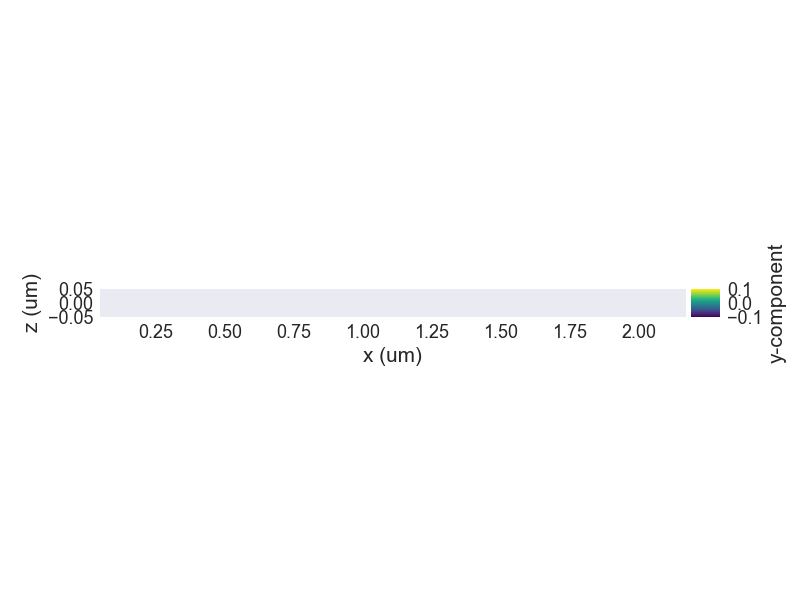

In [52]:
m.plane(y=170e-9).mpl()